In [298]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [299]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
# example of loading the resnet50 model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.applications.vgg19 import VGG19
# small library for seeing the progress of loops.
from tqdm.notebook import tqdm
tqdm().pandas()

|          | 0/? [00:00<?, ?it/s]

In [300]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [301]:
# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [302]:
#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [303]:
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [304]:
#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [305]:
dataset_text ="Flickr8k_text"
dataset_images ="Flicker8k_Dataset"

In [306]:
#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

Length of descriptions = 8092


In [307]:
#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)
#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of vocabulary =  8763


In [36]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features
#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features_Xception.p","wb"))

  0%|          | 0/8091 [00:00<?, ?it/s]

In [308]:
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

In [309]:
def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

In [310]:
def load_features(photos):
    #loading all features
    all_features = load(open("features_Xception.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [311]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [312]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary
from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [313]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

In [314]:
#create input-output sequence pairs from the image description.
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]
            
            
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)


In [315]:
# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [316]:
!pip install GraphViz

In [317]:
from keras.utils.vis_utils import plot_model
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
#os.mkdir("models_NEW")


Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 32, 256)      1939712     input_20[0][0]                   
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 2048)         0           input_19[0][0]     

In [58]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models_New/model_" + str(i) + ".h5")

Epoch 1/1
6000/6000 [==============================] - 1675s 279ms/step - loss: 4.2691
Epoch 1/1
6000/6000 [==============================] - 1418s 236ms/step - loss: 3.6374
Epoch 1/1
6000/6000 [==============================] - 1420s 237ms/step - loss: 3.3779
Epoch 1/1
6000/6000 [==============================] - 1437s 239ms/step - loss: 3.2210
Epoch 1/1
6000/6000 [==============================] - 1432s 239ms/step - loss: 3.1098
Epoch 1/1
6000/6000 [==============================] - 1439s 240ms/step - loss: 3.0300
Epoch 1/1
6000/6000 [==============================] - 1431s 239ms/step - loss: 2.9615
Epoch 1/1
6000/6000 [==============================] - 1457s 243ms/step - loss: 2.9119
Epoch 1/1
6000/6000 [==============================] - 1483s 247ms/step - loss: 2.8667
Epoch 1/1
6000/6000 [==============================] - 1526s 254ms/step - loss: 2.8345


In [318]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import graphviz
import pydot

In [319]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

In [320]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [321]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

In [322]:
#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models_New/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")




man is climbing up large rock


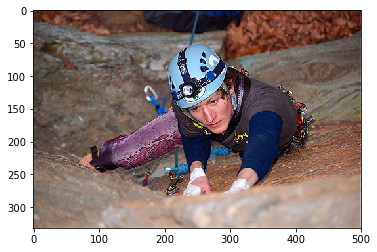

In [325]:
photo = extract_features('Flicker8k_Dataset/111537222_07e56d5a30.jpg', xception_model)
img = Image.open('Flicker8k_Dataset/111537222_07e56d5a30.jpg')
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
description= description[6:9] + description[22:-4]
print(description)
plt.imshow(img)

In [358]:
def lastWord(string):
   
    # split by space and converting
    # string to list and
    lis = list(string.split(" "))
     
    # length of list
    length = len(lis)
     
    # returning last element in list
    return lis[length-1]
 
description = lastWord(description)

In [359]:
description

'rock'




man in red shirt is riding bicycle down the street


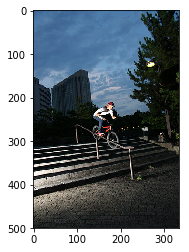

In [65]:
photo = extract_features('Flicker8k_Dataset/3729405438_6e79077ab2.jpg', xception_model)
img = Image.open('Flicker8k_Dataset/3729405438_6e79077ab2.jpg')
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
description= description[6:-4]
print(description)
plt.imshow(img)

In [326]:
import json
import random
import numpy as np
import pandas as pd

import os
#import contractions
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
import keras.utils as ku
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
import nltk
from nltk.corpus import stopwords 

from keras.layers import LSTM, Dense, Dropout, Flatten, Bidirectional, SimpleRNN
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from keras.utils import np_utils

#import lm_scorer

In [327]:
all_lines = []
for line in open("gutenberg-poetry-v001.ndjson"):
    all_lines.append(json.loads(line.strip()))
    
corpus = "\n".join([line['s'] for line in random.sample(all_lines, 1000)])

In [328]:
corpus[0:1000]

'For the distant, happy islands\nShe crept and did not make a sound\nShalt feel what Prato, (not to say the rest)\nWhere no sensation flourished--smallest type\nThose quivering wings composed, that music still!\nOdors sweet in misty veil\nSir John had suddenly grown wond\'rous wise;\nFearless in flight,     the Phoenix its name.\nAs though a grievous sin dismayed\nThe Organs of her Fancie, and with them forge\nI am the old\nAnd happed him in our royal bed."\nAn\' de sheep split \'is lip wid a big broad grin.\nGnashes his teeth, and from his shield\'s tough hide\nNot known before.\nCrimson with Roman blood yon stream shall run.\nIf you\'ll your grammar study,\nRape or Adulterie, where passing faire\nHeart of the World give heed,\nBut no, say nothing: silence is a veil\nWhen Theodore praised some dish, or frankly said\nOn the sacred stronghold of Priam.\nBlest are the dead, forever blest,\nThen spied a puff-ball and essayed\nIn time of old, O thou most brave,\nThe royal wittol Charles, a

# Expand contracted words

In [329]:
import contractions

In [330]:
expanded_data = contractions.fix(corpus)
expanded_data[0:1000]

'For the distant, happy islands\nShe crept and did not make a sound\nShalt feel what Prato, (not to say the rest)\nWhere no sensation flourished--smallest type\nThose quivering wings composed, that music still!\nOdors sweet in misty veil\nSir John had suddenly grown wond\'rous wise;\nFearless in flight,     the Phoenix its name.\nAs though a grievous sin dismayed\nThe Organs of her Fancie, and with them forge\nI am the old\nAnd happed him in our royal bed."\nAn\' de sheep split \'is lip wid a big broad grin.\nGnashes his teeth, and from his shield\'s tough hide\nNot known before.\nCrimson with Roman blood yon stream shall run.\nIf you will your grammar study,\nRape or Adulterie, where passing faire\nHeart of the World give heed,\nBut no, say nothing: silence is a veil\nWhen Theodore praised some dish, or frankly said\nOn the sacred stronghold of Priam.\nBlest are the dead, forever blest,\nThen spied a puff-ball and essayed\nIn time of old, O thou most brave,\nThe royal wittol Charles, 

# Extract new lines from data

In [331]:
# Lowercase all text
raw_text = expanded_data.lower()
raw_text = raw_text
raw_text = raw_text.split('\n')

# Remove unwanted punctuations from lines

In [332]:
text = [txt.strip('"!\"#$%&\)*+-/(:;<=>?@][\\^_}{|~--[0-9]') for txt in raw_text]
text[0:10]

['for the distant, happy islands',
 'she crept and did not make a sound',
 'shalt feel what prato, (not to say the rest',
 'where no sensation flourished--smallest type',
 'those quivering wings composed, that music still',
 'odors sweet in misty veil',
 "sir john had suddenly grown wond'rous wise",
 'fearless in flight,     the phoenix its name.',
 'as though a grievous sin dismayed',
 'the organs of her fancie, and with them forge']

# Tokenize the lines extracted

In [333]:
# Create Tokenizer object to convert words to sequences of integers
tokenizer = Tokenizer(num_words = None, filters = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = False)

In [334]:
# Train tokenizer to the texts
tokenizer.fit_on_texts(text)
total_words = len(tokenizer.word_index) + 1
total_words

2581

# Convert text to ngram sequences

In [335]:
# Convert list of strings into flat dataset of sequences of tokens
sequences = []
for line in text:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        sequences.append(n_gram_sequence)

In [336]:
len(sequences)

6335

# Pad sequences to ensure equal lengths

In [337]:
max_seq_len = max([len(x) for x in sequences])
sequences = np.array(pad_sequences(sequences, maxlen = max_seq_len, padding = 'pre'))

# n-gram sequence - predictors and labels

In [338]:
# Create n-grams sequence predictors and labels
predictors, label = sequences[:, :-1], sequences[:, -1]
label = keras.utils.np_utils.to_categorical(label, num_classes = total_words)

# Input length for model

In [339]:
input_len = max_seq_len - 1

# Stop words for poem generation task

In [340]:
# Used to monitor the generation of sentences in poem
stop_words = set(stopwords.words('english'))

# PART - 1 : Markov model

In [341]:
import markovify

In [342]:
markov_model = markovify.NewlineText(expanded_data)

In [343]:
def gen_poem_markov():
    output_text = ''
    for i in range(5):
        for i in range(random.randrange(1, 4)):
            text = markov_model.make_short_sentence(30)
            print(text)
            output_text += ' ' + text
    return output_text

# PART - 2: Vanilla RNN - Simple word embedding model¶

In [344]:
rnn_model = Sequential()
rnn_model.add(Embedding(total_words, 100, input_length = input_len))
rnn_model.add(SimpleRNN(150))
rnn_model.add(Dropout(0.1))
rnn_model.add(Dense(total_words, activation = 'softmax'))
rnn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# Use 100 epoch for efficacy
rnn_model.fit(predictors, label, epochs = 100, verbose = 1)

Epoch 1/100
6335/6335 [==============================] - 10s 2ms/step - loss: 7.2273
Epoch 2/100
6335/6335 [==============================] - 7s 1ms/step - loss: 6.6408
Epoch 3/100
6335/6335 [==============================] - 7s 1ms/step - loss: 6.3282
Epoch 4/100
6335/6335 [==============================] - 6s 1ms/step - loss: 5.9863
Epoch 5/100
6335/6335 [==============================] - 6s 992us/step - loss: 5.6254
Epoch 6/100
6335/6335 [==============================] - 6s 1ms/step - loss: 5.2479
Epoch 7/100
6335/6335 [==============================] - 6s 992us/step - loss: 4.8689
Epoch 8/100
6335/6335 [==============================] - 6s 996us/step - loss: 4.4735
Epoch 9/100
6335/6335 [==============================] - 6s 994us/step - loss: 4.0894
Epoch 10/100
6335/6335 [==============================] - 6s 966us/step - loss: 3.6928
Epoch 11/100
6335/6335 [==============================] - 6s 994us/step - loss: 3.3226
Epoch 12/100
6335/6335 [==============================] - 6s 

# PART - 3: LSTM - Simple word embedding model

In [345]:
lstm_model = Sequential()
lstm_model.add(Embedding(total_words, 100, input_length = input_len))
lstm_model.add(LSTM(150))
lstm_model.add(Dropout(0.1))
lstm_model.add(Dense(total_words, activation = 'softmax'))
lstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# Use 100 epoch for efficacy
lstm_model.fit(predictors, label, epochs = 100, verbose = 1)

Epoch 1/100
6335/6335 [==============================] - 15s 2ms/step - loss: 7.1905
Epoch 2/100
6335/6335 [==============================] - 12s 2ms/step - loss: 6.6540
Epoch 3/100
6335/6335 [==============================] - 10s 2ms/step - loss: 6.4891
Epoch 4/100
6335/6335 [==============================] - 14s 2ms/step - loss: 6.3509
Epoch 5/100
6335/6335 [==============================] - 12s 2ms/step - loss: 6.2265
Epoch 6/100
6335/6335 [==============================] - 11s 2ms/step - loss: 6.0936
Epoch 7/100
6335/6335 [==============================] - 10s 2ms/step - loss: 5.9477
Epoch 8/100
6335/6335 [==============================] - 10s 2ms/step - loss: 5.7772
Epoch 9/100
6335/6335 [==============================] - 11s 2ms/step - loss: 5.5881
Epoch 10/100
6335/6335 [==============================] - 10s 2ms/step - loss: 5.3968
Epoch 11/100
6335/6335 [==============================] - 10s 2ms/step - loss: 5.1966
Epoch 12/100
6335/6335 [==============================] - 10s 2

# Part - 4: Bidirectional LSTM - Simple word embedding model¶

In [346]:
bi_lstm_model = Sequential()
bi_lstm_model.add(Embedding(total_words, 100, input_length = input_len))
bi_lstm_model.add(Bidirectional(LSTM(100)))
bi_lstm_model.add(Dropout(0.1))
bi_lstm_model.add(Dense(total_words, activation = 'softmax'))
bi_lstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# Use 100 epoch for efficacy
bi_lstm_model.fit(predictors, label, epochs = 100, verbose = 1)

Epoch 1/100
6335/6335 [==============================] - 16s 3ms/step - loss: 7.2020
Epoch 2/100
6335/6335 [==============================] - 11s 2ms/step - loss: 6.6600
Epoch 3/100
6335/6335 [==============================] - 11s 2ms/step - loss: 6.4667
Epoch 4/100
6335/6335 [==============================] - 11s 2ms/step - loss: 6.2839
Epoch 5/100
6335/6335 [==============================] - 11s 2ms/step - loss: 6.1031
Epoch 6/100
6335/6335 [==============================] - 11s 2ms/step - loss: 5.9080: 0s - loss: 5.908
Epoch 7/100
6335/6335 [==============================] - 11s 2ms/step - loss: 5.7024
Epoch 8/100
6335/6335 [==============================] - 11s 2ms/step - loss: 5.4927
Epoch 9/100
6335/6335 [==============================] - 11s 2ms/step - loss: 5.2623
Epoch 10/100
6335/6335 [==============================] - 11s 2ms/step - loss: 5.0343
Epoch 11/100
6335/6335 [==============================] - 11s 2ms/step - loss: 4.8059
Epoch 12/100
6335/6335 [=====================

6335/6335 [==============================] - 9s 1ms/step - loss: 0.4192
Epoch 96/100
6335/6335 [==============================] - 9s 1ms/step - loss: 0.4042
Epoch 97/100
6335/6335 [==============================] - 9s 1ms/step - loss: 0.3920A: 0s - loss: 
Epoch 98/100
6335/6335 [==============================] - 9s 1ms/step - loss: 0.3888
Epoch 99/100
6335/6335 [==============================] - 9s 1ms/step - loss: 0.3947
Epoch 100/100
6335/6335 [==============================] - 9s 1ms/step - loss: 0.3927


# Using GloVe embedding

In [347]:
word_index = tokenizer.word_index
print(len(word_index))

2580


In [348]:
def cal_embedding_matrix(word_index):
    embedded_words = {}
    with open('glove.6B.100d.txt', encoding="utf8") as file:
        for line in file:
            words, coeff = line.split(maxsplit=1)
            coeff = np.array(coeff.split(),dtype = float)
            embedded_words[words] = coeff

    embedding_matrix = np.zeros((len(word_index)+1, 100))
    for word, i in word_index.items():
        embedding_vector = embedded_words.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [349]:
embedding_matrix = cal_embedding_matrix(word_index)

In [350]:
print('Shape of embedding matrix:',embedding_matrix.shape)

Shape of embedding matrix: (2581, 100)


# Part - 5 : Vanilla RNN - Glove embedding model

In [351]:
rnn_glove_model = Sequential()
rnn_glove_model.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix], input_length = input_len))
rnn_glove_model.add(SimpleRNN(150))
rnn_glove_model.add(Dropout(0.1))
rnn_glove_model.add(Dense(total_words, activation = 'softmax'))
rnn_glove_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# Use 100 epoch for efficacy
rnn_glove_model.fit(predictors, label, epochs = 100, verbose = 1)

Epoch 1/100
6335/6335 [==============================] - 9s 1ms/step - loss: 7.2204
Epoch 2/100
6335/6335 [==============================] - 6s 970us/step - loss: 6.5116
Epoch 3/100
6335/6335 [==============================] - 5s 856us/step - loss: 6.0310
Epoch 4/100
6335/6335 [==============================] - 5s 847us/step - loss: 5.5160
Epoch 5/100
6335/6335 [==============================] - 5s 856us/step - loss: 4.9666
Epoch 6/100
6335/6335 [==============================] - 5s 828us/step - loss: 4.4099
Epoch 7/100
6335/6335 [==============================] - 5s 840us/step - loss: 3.8605
Epoch 8/100
6335/6335 [==============================] - 5s 843us/step - loss: 3.3268
Epoch 9/100
6335/6335 [==============================] - 5s 831us/step - loss: 2.8285
Epoch 10/100
6335/6335 [==============================] - 5s 831us/step - loss: 2.3970
Epoch 11/100
6335/6335 [==============================] - 5s 833us/step - loss: 2.0333
Epoch 12/100
6335/6335 [==============================

6335/6335 [==============================] - 5s 812us/step - loss: 0.4008
Epoch 96/100
6335/6335 [==============================] - 5s 828us/step - loss: 0.4041
Epoch 97/100
6335/6335 [==============================] - 5s 829us/step - loss: 0.4082
Epoch 98/100
6335/6335 [==============================] - 5s 825us/step - loss: 0.3999
Epoch 99/100
6335/6335 [==============================] - 5s 822us/step - loss: 0.4033
Epoch 100/100
6335/6335 [==============================] - 5s 843us/step - loss: 0.3973


# PART - 6 : LSTM - Glove embedding model

In [352]:
lstm_glove_model = Sequential()
lstm_glove_model.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix], input_length = input_len))
lstm_glove_model.add(LSTM(150))
lstm_glove_model.add(Dropout(0.1))
lstm_glove_model.add(Dense(total_words, activation = 'softmax'))
lstm_glove_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# Use 100 epoch for efficacy
lstm_glove_model.fit(predictors, label, epochs = 100, verbose = 1)

Epoch 1/100
6335/6335 [==============================] - 11s 2ms/step - loss: 7.1910
Epoch 2/100
6335/6335 [==============================] - 9s 1ms/step - loss: 6.6549
Epoch 3/100
6335/6335 [==============================] - 8s 1ms/step - loss: 6.4386
Epoch 4/100
6335/6335 [==============================] - 8s 1ms/step - loss: 6.1647
Epoch 5/100
6335/6335 [==============================] - 8s 1ms/step - loss: 5.8399
Epoch 6/100
6335/6335 [==============================] - 8s 1ms/step - loss: 5.4920
Epoch 7/100
6335/6335 [==============================] - 8s 1ms/step - loss: 5.1284
Epoch 8/100
6335/6335 [==============================] - 8s 1ms/step - loss: 4.7625
Epoch 9/100
6335/6335 [==============================] - 8s 1ms/step - loss: 4.3906
Epoch 10/100
6335/6335 [==============================] - 8s 1ms/step - loss: 4.0134
Epoch 11/100
6335/6335 [==============================] - 8s 1ms/step - loss: 3.6499
Epoch 12/100
6335/6335 [==============================] - 8s 1ms/step - l

# Part - 7: Bi-directional LSTM Glove embedding model¶

In [353]:
bi_lstm_glove_model = Sequential()
bi_lstm_glove_model.add(Embedding(len(word_index)+1, 100, weights=[embedding_matrix], input_length = input_len))
bi_lstm_glove_model.add(Bidirectional(LSTM(100)))
bi_lstm_glove_model.add(Dropout(0.1))
bi_lstm_glove_model.add(Dense(total_words, activation = 'softmax'))
bi_lstm_glove_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# Use 100 epoch for efficacy
bi_lstm_glove_model.fit(predictors, label, epochs = 100, verbose = 1)

Epoch 1/100
6335/6335 [==============================] - 15s 2ms/step - loss: 7.2175
Epoch 2/100
6335/6335 [==============================] - 12s 2ms/step - loss: 6.6402
Epoch 3/100
6335/6335 [==============================] - 11s 2ms/step - loss: 6.3552
Epoch 4/100
6335/6335 [==============================] - 11s 2ms/step - loss: 6.0228
Epoch 5/100
6335/6335 [==============================] - 11s 2ms/step - loss: 5.6673
Epoch 6/100
6335/6335 [==============================] - 11s 2ms/step - loss: 5.3047
Epoch 7/100
6335/6335 [==============================] - 11s 2ms/step - loss: 4.9352
Epoch 8/100
6335/6335 [==============================] - 11s 2ms/step - loss: 4.5481
Epoch 9/100
6335/6335 [==============================] - 11s 2ms/step - loss: 4.1594
Epoch 10/100
6335/6335 [==============================] - 11s 2ms/step - loss: 3.7788
Epoch 11/100
6335/6335 [==============================] - 11s 2ms/step - loss: 3.4017
Epoch 12/100
6335/6335 [==============================] - 11s 2

# POEM generation function

In [360]:
# Function to generate line - based on STOP WORDS at the end of generated sentence. And every sentence should have only 5 words
def generate_line(init_text, max_seq_len, num_sen, model):
    output_word = ''
    num_words = 5  
    last_word = 'a'
    text = init_text
    init_words = nltk.word_tokenize(text)
    
    while last_word in stop_words:
        if num_sen == 0:
            num_words = num_words - len(init_words)
    
        output_text = ''
        for j in range(num_words):
            token_list = tokenizer.texts_to_sequences([text])[0]
            token_list = pad_sequences([token_list], maxlen = max_seq_len - 1, padding = 'pre')
            predict = model.predict(token_list, verbose = 0)
            predicted=np.argmax(predict,axis=1)

            for word, index in tokenizer.word_index.items():
                if index == predicted:
                    output_word = word
                    break

            text += ' ' + output_word
            if num_sen == 0:
                output_text = text
            else:       
                output_text += ' ' + output_word
        words = nltk.word_tokenize(output_text)
        last_word = words[-1]
        
    return output_text  

def format_line(text, num_sen, sen):
    text = text[:1].upper() + text[1:]
    words = nltk.word_tokenize(text)
    last_word = words[-1]
    if sen != num_sen-1:
        if last_word not in stop_words:
            text = text + ','
    else:
        text = text + '.'
    return text

# Function to generate poem - multiple lines
## Arguments (sample text, padding length, number of sentences needed, model)
def generate_poem(text, max_seq_len, num_sen, model):
    output_sentence = text
    output = ''
    for sen in range(num_sen):
        gen_sent = generate_line(output_sentence, max_seq_len, sen, model)  
        sentence = format_line(gen_sent, num_sen, sen)
        output_sentence += '' + sentence
        print(sentence)
        output += sentence
        text = output_sentence
    return output

In [361]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [362]:
description

'rock'

# Poem generation

# Vanilla RNN - Simple word embedding model

In [363]:
## Arguments - (sample text, padding length, number of sentences needed, model)
gen_text_rnn = generate_poem(description, max_seq_len, 5, rnn_model)

Rock thus a reason s a fool lost,
 flame two of state waste,
 not thine eye not shut,
 sixth circle heresiarchs farinata degli,
 flicker of songs smiled wawes.


# LSTM - Simple word embedding model

In [364]:
## Arguments - (sample text, padding length, number of sentences needed, model)
# gen_text_lstm = generate_poem("Love to", max_seq_len, 5, lstm_model)
gen_text_lstm = generate_poem(description, max_seq_len, 5, lstm_model)

Rock by the deed shall,
 gain a glorious prize thy,
 honour spread feet an apparition,
 wilder llevará thence incense fun,
 incense apparition wilder perchance heart.


# Bidirectional LSTM - Simple word embedding model

In [365]:
## Arguments - (sample text, padding length, number of sentences needed, model)
# gen_text_bilstm = generate_poem("Love to", max_seq_len, 5, bi_lstm_model)
gen_text_bilstm = generate_poem(description, max_seq_len, 5, bi_lstm_model)

Rock ve i ween the helpless prize stane,
 us to the first glimpse,
 of worse worse roses sign,
 distant worse and you incense,
 roses then to me thy.


# Vanilla RNN - Glove embedding model

In [366]:
## Arguments - (sample text, padding length, number of sentences needed, model)
# gen_text_rnn_glove = generate_poem("Love to", max_seq_len, 5, rnn_glove_model)
gen_text_rnn_glove = generate_poem(description, max_seq_len, 5, rnn_glove_model)

Rock upon the summit on the frozen ground,
 devil to give the cruel,
 this i held myself secure,
 flight with little crimson feet,
 kindred hours for me thy.


# LSTM - Glove embedding model

In [367]:
## Arguments - (sample text, padding length, number of sentences needed, model)
gen_text_lstm_glove = generate_poem(description, max_seq_len, 5, lstm_glove_model)

Rock upon the threshold of my door and i i mourned,
 my work undone with flame,
 i admire loathe them many,
 a mighty land hath made,
 day may at here thy.


# Bi Directional LSTM - Glove embedding model

In [368]:
## Arguments - (sample text, padding length, number of sentences needed, model)
# Sweet life, There he sang
gen_text_bilstm_glove = generate_poem(description, max_seq_len, 5, bi_lstm_glove_model)

Rock the friendless worm drew,
 near she beheld a single,
 say ye how i shake,
 crack in some fair windows,
 and us and truth us.


# Evaluate - Probability

In [369]:
from lm_scorer.models.auto import AutoLMScorer
scorer = AutoLMScorer.from_pretrained("gpt2-large")

def prob_score(sentence):
    return scorer.sentence_score(sentence, reduce='mean')

In [370]:
print('Vanilla RNN - tokenized data Model text')
print(gen_text_rnn)
print(prob_score(gen_text_rnn))

Vanilla RNN - tokenized data Model text
Rock thus a reason s a fool lost, flame two of state waste, not thine eye not shut, sixth circle heresiarchs farinata degli, flicker of songs smiled wawes.
0.019092347472906113


In [371]:
print('LSTM - tokenized data Model text')
print(gen_text_lstm)
print(prob_score(gen_text_lstm))

LSTM - tokenized data Model text
Rock by the deed shall, gain a glorious prize thy, honour spread feet an apparition, wilder llevará thence incense fun, incense apparition wilder perchance heart.
0.09867318719625473


In [372]:
print('BiLSTM - tokenized data Model text')
print(gen_text_bilstm)
print(prob_score(gen_text_bilstm))

BiLSTM - tokenized data Model text
Rock ve i ween the helpless prize stane, us to the first glimpse, of worse worse roses sign, distant worse and you incense, roses then to me thy.
0.01826399192214012


In [373]:
print('Vanilla RNN - glove embedding Model text')
print(gen_text_rnn_glove)
print(prob_score(gen_text_rnn_glove))

Vanilla RNN - glove embedding Model text
Rock upon the summit on the frozen ground, devil to give the cruel, this i held myself secure, flight with little crimson feet, kindred hours for me thy.
0.045714814215898514


In [374]:
print('LSTM - glove embedding Model text')
print(gen_text_lstm_glove)
print(prob_score(gen_text_lstm_glove))

LSTM - glove embedding Model text
Rock upon the threshold of my door and i i mourned, my work undone with flame, i admire loathe them many, a mighty land hath made, day may at here thy.
0.03082793951034546


In [375]:
print('Bidirectional LSTM - glove embedding Model text')
print(gen_text_bilstm_glove)
print(prob_score(gen_text_bilstm_glove))

Bidirectional LSTM - glove embedding Model text
Rock the friendless worm drew, near she beheld a single, say ye how i shake, crack in some fair windows, and us and truth us.
0.04528085142374039


# Evaluate - Perplexity

In [376]:
import math
import torch
from pytorch_pretrained_bert import OpenAIGPTTokenizer, OpenAIGPTModel, OpenAIGPTLMHeadModel

In [377]:
# Load pre-trained model (weights)
gpt_model = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
gpt_model.eval()
# Load pre-trained model tokenizer (vocabulary)
gpt_tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [378]:
def ppl_score(sentence):
    tokenize_input = gpt_tokenizer.tokenize(sentence)
    tensor_input = torch.tensor([gpt_tokenizer.convert_tokens_to_ids(tokenize_input)])
    loss = gpt_model(tensor_input, lm_labels=tensor_input)
    return math.exp(loss)

In [379]:
print('Vanilla RNN - tokenized data Model text')
print(gen_text_rnn)
print(ppl_score(gen_text_rnn))

Vanilla RNN - tokenized data Model text
Rock thus a reason s a fool lost, flame two of state waste, not thine eye not shut, sixth circle heresiarchs farinata degli, flicker of songs smiled wawes.
2487.9404764772253


In [380]:
print('LSTM - tokenized data Model text')
print(gen_text_lstm)
print(ppl_score(gen_text_lstm))

LSTM - tokenized data Model text
Rock by the deed shall, gain a glorious prize thy, honour spread feet an apparition, wilder llevará thence incense fun, incense apparition wilder perchance heart.
2980.2686724577184


In [381]:
print('BiLSTM - tokenized data Model text')
print(gen_text_bilstm)
print(ppl_score(gen_text_bilstm))

BiLSTM - tokenized data Model text
Rock ve i ween the helpless prize stane, us to the first glimpse, of worse worse roses sign, distant worse and you incense, roses then to me thy.
1512.0719378872482


In [382]:
print('Vanilla RNN - glove embedding Model text')
print(gen_text_rnn_glove)
print(ppl_score(gen_text_rnn_glove))

Vanilla RNN - glove embedding Model text
Rock upon the summit on the frozen ground, devil to give the cruel, this i held myself secure, flight with little crimson feet, kindred hours for me thy.
662.3119039411733


In [383]:
print('LSTM - glove embedding Model text')
print(gen_text_lstm_glove)
print(ppl_score(gen_text_lstm_glove))

LSTM - glove embedding Model text
Rock upon the threshold of my door and i i mourned, my work undone with flame, i admire loathe them many, a mighty land hath made, day may at here thy.
636.3113577296851


In [384]:
print('Bidirectional LSTM - glove embedding Model text')
print(gen_text_bilstm_glove)
print(ppl_score(gen_text_bilstm_glove))

Bidirectional LSTM - glove embedding Model text
Rock the friendless worm drew, near she beheld a single, say ye how i shake, crack in some fair windows, and us and truth us.
853.041658509044
